## Feature Pipeline

- TODO: list steps



### Imports

In [1]:
import numpy as np
import pandas as pd 
import os


#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem  import PorterStemmer

from sklearn.preprocessing import LabelEncoder 
import sklearn.preprocessing as pr
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.preprocessing.text import Tokenizer, one_hot
from keras.utils import pad_sequences

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import hopsworks

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/evaengel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2023-01-08 18:26:23.082843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Exploratory Data Analysis

In [2]:
# Load FINANCE data
finance_data = pd.read_csv('../data/finance_data/all-data.csv', names=['Sentiment','Headline'], encoding='latin-1')
# Output first five rows
finance_data.head()

,Sentiment,Headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [3]:
# Load COVID data
## positive sentiment is represented by '1' and negative sentiment by '0
covid_data = pd.read_csv('../data/covid_data/raw_data.csv', usecols = ['Sentiment','Headline'], encoding='latin-1')
covid_data['Sentiment'] = covid_data['Sentiment'].map({0: 'negative', 1: 'positive'})

# Output first five rows
covid_data.head()

,Headline,Sentiment
0,"Coronavirus cases reach 2,438 in Rajasthan; 81...",negative
1,"Coronavirus cases in Delhi surge to 3,439 afte...",negative
2,"Anguished, I'll always recall our interactions...",positive
3,It's a terrible week for Indian cinema: Rahul ...,negative
4,Delhi Police perform 'parikrama' of AIIMS to t...,positive


In [4]:
# Load SEN_R data
## positive sentiment is represented by '1' and negative sentiment by '0
sen_R_data = pd.read_csv('../data/sen_data/SEN_en_R.csv', usecols = ['majority_label','headline'], encoding='latin-1')
sen_R_data = sen_R_data.rename(columns = {"majority_label": "Sentiment", "headline": "Headline"})
sen_R_data['Sentiment'] = sen_R_data['Sentiment'].map({'neg': 'negative', 'pos': 'positive', 'neutr': 'neutral'})
# Output first five rows
sen_R_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1271 entries, 0 to 1270
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Headline   1271 non-null   object
 1   Sentiment  1237 non-null   object
dtypes: object(2)
memory usage: 20.0+ KB


In [5]:
# Load SEN_AMT data
## positive sentiment is represented by '1' and negative sentiment by '0
sen_AMT_data = pd.read_csv('../data/sen_data/SEN_en_AMT.csv', usecols = ['majority_label','headline'], encoding='latin-1')
sen_AMT_data = sen_AMT_data.rename(columns = {"majority_label": "Sentiment", "headline": "Headline"})
sen_AMT_data['Sentiment'] = sen_AMT_data['Sentiment'].map({'neg': 'negative', 'pos': 'positive', 'neutr': 'neutral'})
# Output first five rows
sen_AMT_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1361 entries, 0 to 1360
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Headline   1361 non-null   object
 1   Sentiment  1344 non-null   object
dtypes: object(2)
memory usage: 21.4+ KB


In [6]:
# Combine all data sets

data = pd.concat([finance_data,covid_data,sen_R_data,sen_AMT_data], ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11550 entries, 0 to 11549
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  11499 non-null  object
 1   Headline   11550 non-null  object
dtypes: object(2)
memory usage: 180.6+ KB


In [7]:
# Check for missing data
data.isnull().sum()

Sentiment    51
Headline      0
dtype: int64

<AxesSubplot: xlabel='Sentiment'>

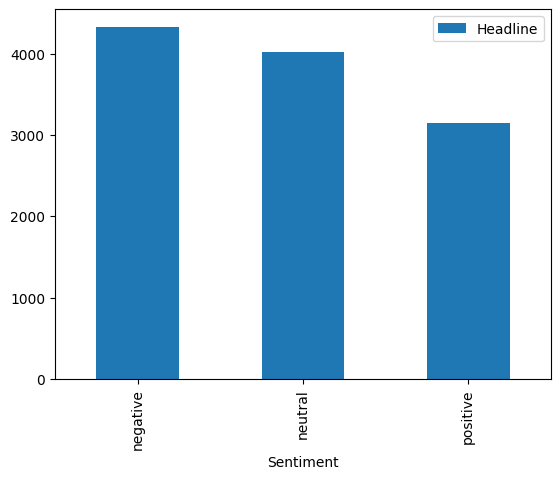

In [8]:
# The distribution of sentiments
data.groupby('Sentiment').count().plot(kind='bar')

<AxesSubplot: >

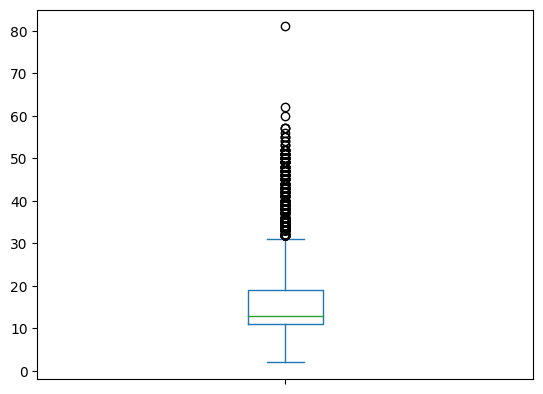

In [9]:
# Calculate headline lengths
headline_len = pd.Series([len(headline.split()) for headline in data['Headline']])

# The distribution of headline text lengths
headline_len.plot(kind='box')

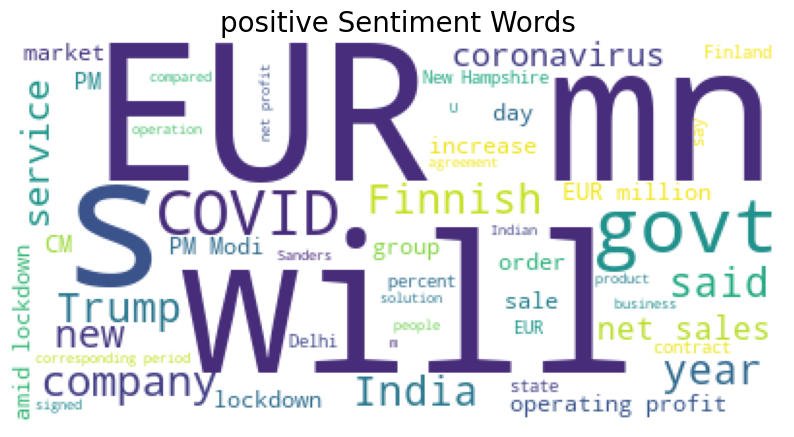

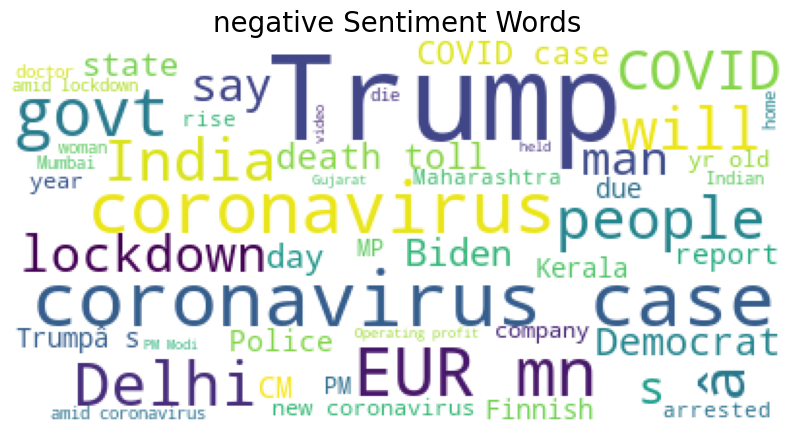

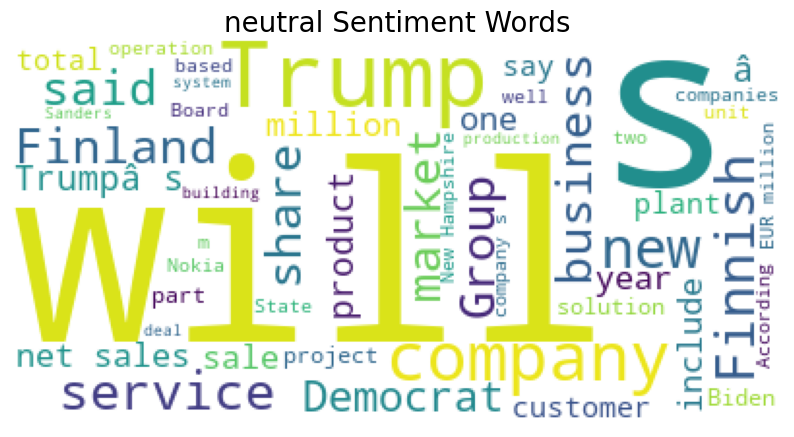

In [10]:
#### Visualizing data into wordclouds


from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: Positive/Negative/Neutral
    '''
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.Sentiment==category]['Headline']])
                          
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()
    
# Positive tweet words
wordcount_gen(data, 'positive')
     
# Negative tweet words
wordcount_gen(data, 'negative')
     
# Neutral tweet words
wordcount_gen(data, 'neutral')

## Preprocessing

We remove the Stop words like 'the' , 'of' , 'is' , 'a' from every sentence as they do not contribute to the algorithm performance and then perform Stemming on each word where we remove the suffix of the word and reduce it to it's root word. eg.) history-histori

In [11]:
def headline_to_sequence(headline):
    ''' Convert headline text into a sequence of words '''
    ps = PorterStemmer()

    text = re.sub(r'[^a-zA-Z0-9]',' ', headline)

    # convert to lowercase
    text = text.lower()

    # tokenize
    text = text.split()

    #remove stopwords and apply stemming
    text = [ps.stem(word) for word in text if not word in stopwords.words('english')]
    text = ' '.join(text)
   
    return text

TODO: above: doesnt remove all numbers

In [17]:
def preprocess_inputs(df):
    df = df.copy()

    # drop missing rows
    df.dropna(axis=0, inplace=True)
    df.reset_index(drop=True, inplace=True)


    df['Headline'] = df['Headline'].apply(lambda x: headline_to_sequence(x)) 

    # Encode labels
    le = LabelEncoder()
    df['Sentiment'] = le.fit_transform(df['Sentiment'])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print('The mapping of the labels: ', le_name_mapping)
    
    #X_train, X_test, y_train, y_test = train_test_split(sequences, y, train_size=0.7, shuffle=True, random_state=1)
    return df
    #return X_train, X_test, y_train, y_test

In [18]:
df_string = preprocess_inputs(data)

The mapping of the labels:  {'negative': 0, 'neutral': 1, 'positive': 2}


### One Hot Representation

One of the most important step in NLP is to convert text data to vector so that it generalizes well to the predictions . One of the word representation technique is One Hot Representation where we assign index to the words based on a vocabulary size

In [19]:
df_string

,Sentiment,Headline
0,1,accord gran compani plan move product russia a...
1,1,technopoli plan develop stage area less 100 00...
2,0,intern electron industri compani elcoteq laid ...
3,2,new product plant compani would increas capac ...
4,2,accord compani updat strategi year 2009 2012 b...
...,...,...
11494,2,hous republican refut schiff impeach report
11495,0,democrat fractur fairi tale
11496,1,senat republican push new privaci initi
11497,0,republican propos feed countri swamp


In [50]:
voc_size = 5000   #arbitrarily choosen
df_int = df_string.copy()
df_int['Headline'] = df_string['Headline'].apply(lambda x: one_hot(x,voc_size))

### Padding

TODO rewrite: Before passing One Hot representation to the embedding layer , we need to make sure that all the length of the sentences are equal . If it is not the same , we apply pre padding with zeroes to make the lengths equal by first defining a sentence length .
All the neural networks require to have inputs that have the same shape and size. However, when we pre-process and use the texts as inputs for our model e.g. LSTM, not all the sentences have the same length. In other words, naturally, some of the sentences are longer or shorter. We need to have the inputs with the same size, this is where the padding is necessary.

In [51]:
max_len = 60         # arbitrarily chosen

# Pad sequences to the same length
df = df_int.copy()

df['Headline'] = df_int['Headline'].apply(lambda x: pad_sequences([x], padding='post', maxlen = max_len)[0])

In [ ]:
df.astype('int32').dtypes

In [67]:
df['Headline'][11495]

array([2844, 4644, 2130, 3614,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [53]:
df['Headline'].astype('np.array').dtypes

TypeError: data type 'np.array' not understood

In [54]:
df['Headline'][11495][-1]

0

In [65]:
df['Headline'][0]

array([ 442, 3964, 4698, 4498,  122, 2675, 4520, 2651, 4698,   94,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [56]:
type(df['Headline'][0])

numpy.ndarray

### Connect to Hopsworks Feature Store

In [61]:
project = hopsworks.login()

fs = project.get_feature_store() 

headlines_sentiment_fg = fs.get_or_create_feature_group(
    name = 'headlines_sentiment_fg',
    primary_key =['Headline','Sentiment'],
    version = 2
)

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/5322
Connected. Call `.close()` to terminate connection gracefully.


### Uploading new data to the Feature Store

In [62]:
headlines_sentiment_fg.insert(df, write_options={"wait_for_job" : False})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/5322/fs/5242/fg/14771


Uploading Dataframe: 0.00% |          | Rows 0/11499 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/5322/jobs/named/headlines_sentiment_fg_2_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x1365dab80>, None)

In [63]:
df.to_csv('../data/preprocessed_data.csv', index=False)

### NOT USED: Bag of words (BOW) feature extraction

In [ ]:
vocabulary_size = 5000

# headline have already been preprocessed hence dummy function will be passed in 
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 

#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the headlines
X = count_vector.fit_transform(X).toarray()


#Normalize BoW features in training and test set
X = pr.normalize(X, axis=1)